In [83]:
import os

os.environ["JAVA_HOME"] = "C:\\Program Files\\Java\\jdk-24"
print(os.environ.get("JAVA_HOME"))

os.environ["OPENAI_API_KEY"] = "sk-socialthingum-Lzt6aXn0b7k2ia0tjcmqT3BlbkFJLWlJZwLsUuKQ6OSfzwgC"

C:\Program Files\Java\jdk-24


In [84]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnableSequence
from langchain.output_parsers import ResponseSchema, StructuredOutputParser
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
import pandas as pd
import pyterrier as pt  
import json

from langchain_core.messages import HumanMessage
from sqlalchemy import text
from google.cloud.sql.connector import Connector, IPTypes
from typing import Any
from typing import Annotated, Literal
from pydantic import BaseModel, Field
from typing_extensions import TypedDict
from langgraph.types import interrupt, Command
from langchain.output_parsers import StructuredOutputParser, ResponseSchema
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode
from langchain_core.messages import AIMessage
from langchain_openai import ChatOpenAI
from langgraph.graph import END, StateGraph, START
from langgraph.graph.message import AnyMessage, add_messages
from langchain_core.messages import ToolMessage
from langchain_core.runnables import RunnableLambda, RunnableWithFallbacks
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate


In [85]:
if not pt.started():
    pt.init()

C:\Users\figio\AppData\Local\Temp\ipykernel_2832\3057724015.py:1: DeprecationWarning: Call to deprecated function (or staticmethod) started. (use pt.java.started() instead) -- Deprecated since version 0.11.0.
  if not pt.started():


## Setup

In [86]:
df = pd.read_csv("C:\\Users\\figio\Desktop\\tryKaggle\\archive\\sampled_dataset.csv")
print(df.columns)
df = df.rename(columns={'Unnamed: 0': 'id'})
print(df.head())

<>:1: SyntaxWarning: invalid escape sequence '\D'
<>:1: SyntaxWarning: invalid escape sequence '\D'
C:\Users\figio\AppData\Local\Temp\ipykernel_2832\3405669283.py:1: SyntaxWarning: invalid escape sequence '\D'
  df = pd.read_csv("C:\\Users\\figio\Desktop\\tryKaggle\\archive\\sampled_dataset.csv")


Index(['Unnamed: 0', 'title', 'ingredients', 'directions', 'link', 'source',
       'NER', 'dir_word_count', 'ner_len'],
      dtype='object')
        id                         title  \
0  2015528  Marinated Flank Steak Recipe   
1  1608734           French Chicken Stew   
2   778500                Glazed Carrots   
3  1334975               Moms Pie Dough    
4   116562      Pretzel Salad Or Dessert   

                                         ingredients  \
0  ["1 1/2 pound flank steak", "1/2 c. finely min...   
1  ["1 tablespoon rosemary", "1 teaspoon thyme", ...   
2  ["3 to 4 carrots", "1 1/2 Tbsp. butter", "1/3 ...   
3  ["4.5 Cups Flour", "1.5 Tsp Salt", "Pinch Baki...   
4  ["2 c. crushed small thin pretzels (sticks)", ...   

                                          directions  \
0  ['Remove tenderloin from steak.', 'Score meat....   
1  ["combine all ingredients in slow cooker (6 qu...   
2  ['Cook 3 to 4 carrots; cut crosswise in 1-inch...   
3  ['Mix all dry ingredients in

## Objects 

In [87]:
llm = ChatOpenAI(model="gpt-4", temperature=0.7)

In [88]:
class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

## RAG

In [89]:
# Percorso assoluto all'indice
index_path = r"C:\\Users\\figio\\Desktop\\cooking-mama\\Riccardo Finigi\\index_fields"

# Verifica se l'indice esiste già
if os.path.exists(index_path) and os.path.exists(os.path.join(index_path, "data.properties")):
    print("✔️ Index already exists. Using existing index.")
    indexref = index_path
else:
    print("🛠️ Index not found. Building new index...")

    documents_fields = [
        {
            'docno': str(row['id']),  # usa l'id reale
            'title': row['title'],
            'ingredients': row['ingredients'],
        }
        for _, row in df.iterrows()
    ]

    os.makedirs(index_path, exist_ok=True)

    indexer_fields = pt.IterDictIndexer(index_path)
    indexref = indexer_fields.index(
        documents_fields,
        fields=["title", "ingredients"],
        meta={'docno': 20, 'title': 512, 'ingredients': 1024}
    )

# Costruisci oggetto Index e motore di retrieval
index_fields = pt.IndexFactory.of(indexref)
bm25_ingredients = pt.terrier.Retriever(
    index_fields,
    wmodel="BM25",
    controls={"w": "1.0"},
    metadata=["docno", "ingredients"],
    field="ingredients"
)



✔️ Index already exists. Using existing index.
17:23:13.114 [main] WARN org.terrier.structures.FSADocumentIndex -- This index has fields, but FSADocumentIndex is used (which stores fields lengths on disk); If using field-based models such as BM25F, change to index.document.class in the index  properties file to FSAFieldDocumentIndex or FSADocumentIndexInMemFields to support efficient retrieval. If you don't use (e.g.) BM25F, this warning can be ignored


In [90]:
index_path_directions = r"C:\\Users\\figio\\Desktop\\cooking-mama\\Riccardo Finigi\\index_directions"


if os.path.exists(index_path_directions) and os.path.exists(os.path.join(index_path_directions, "data.properties")):
    print("✔️ Index already exists. Using existing index.")
    indexref_2 = index_path_directions
else:
    print("🛠️ Index not found. Building new index fir directions...")
    
    documents_fields = [
        {
            'docno': str(row['id']),  # usa l'id reale
            'title': row['title'],
            'directions': row['directions'],
        }
        for _, row in df.iterrows()
    ]

    os.makedirs(index_path_directions, exist_ok=True)

    indexer_fields = pt.IterDictIndexer(index_path_directions)
    indexref_2 = indexer_fields.index(
        documents_fields,
        fields=["title", "directions"],
        meta={'docno': 20, 'title': 512, 'directions': 4096}
    )
    

# Costruisci oggetto Index e motore di retrieval
index_fields = pt.IndexFactory.of(indexref_2)
bm25_directions = pt.terrier.Retriever(
    index_fields,
    wmodel="BM25",
    controls={"w": "1.0"},
    metadata=["docno", "directions"],
    field="directions"
)

✔️ Index already exists. Using existing index.
17:23:13.336 [main] WARN org.terrier.structures.FSADocumentIndex -- This index has fields, but FSADocumentIndex is used (which stores fields lengths on disk); If using field-based models such as BM25F, change to index.document.class in the index  properties file to FSAFieldDocumentIndex or FSADocumentIndexInMemFields to support efficient retrieval. If you don't use (e.g.) BM25F, this warning can be ignored


## Prompts

### 1

In [91]:
prompt_system_ingrs = """
You are a creative and helpful cooking assistant.

The user will provide a list of available ingredients.  
Your task is to create a complete and realistic recipe using **only those ingredients** — do not invent or add anything not included in the list.

The recipe must include:
- A clear and descriptive title
- Step-by-step preparation instructions

Important rules:
- Do NOT use any ingredient that is not listed.
- If a necessary item (e.g., salt, oil, water) is missing, do NOT assume it's available — exclude it.
- You can adjust the form or quantity of the ingredients (e.g., chop, grate, blend), but not add new ones.
- If the ingredients are unusual together, invent a plausible or creative dish that still makes good use of them.

Output your response in the following JSON format:

{{
	"title": string  // The title of the recipe
	"list_of_steps": string  // A list of steps to prepare the dish, only the list
}}

DO NOT return any other text or explanation, just the JSON.

Example, take some ispiration from this:
{Example}

"""

In [92]:
response_schemas_2 = [
    ResponseSchema(
        name='title',
        description='The title of the recipe',
    ),
    ResponseSchema(
        name='list_of_steps',
        description='A list of steps to prepare the dish, only the list',
    )
]

In [93]:
output_parser_2 = StructuredOutputParser.from_response_schemas(response_schemas_2)

In [94]:
prompt_system_ingrs_ = ChatPromptTemplate.from_messages(
    [('system', prompt_system_ingrs), ('user', '{messages}')]
).partial(format_instructions=output_parser_2.get_format_instructions())

### 2

In [95]:
prompts_rigeneration_ask = """
You are a cooking expert, and your task is to improve the recipe. The recipe has already been generated and is visible in the message list. 
Your job is to determine whether additional information is needed from a tool to improve the recipe, or if you should proceed with a new generation using the user's corrections. 

Your task is to decide whether to use a tool or not. There are two possible tools available:
- `retrieve_by_ingredients`: a tool that retrieves recipes based on the ingredients provided by the user.
- `retrieve_by_directions`: a tool that retrieves recipes based on the directions provided for preparing the dish.

Output your response in the following JSON format:
{{
    "tool": "retrieve_by_ingredients" or "retrieve_by_directions",
    "reasoning": "message to the user",
    "action": "what change in the recipe"
}}

call always the tool, even if you don't need it, to increase the information in the recipe.
"""

In [96]:
prompts_rigeneration_ = ChatPromptTemplate.from_messages(
    [('system', prompts_rigeneration_ask), ('user', '{messages}')]
)

### 3

In [97]:
prompt_regen = """
You are a creative and helpful cooking assistant.

The user will provide a list of message.  Use the messages to retrieve all the information that is needed to regenerate the recipe, because this is a regeneration following new directions.
Your task is to create a complete and realistic recipe using **only those ingredients** — do not invent or add anything not included in the list.

The recipe must include:
- A clear and descriptive title
- Step-by-step preparation instructions

Important rules:
- Do NOT use any ingredient that is not listed.
- If a necessary item (e.g., salt, oil, water) is missing, do NOT assume it's available — exclude it.
- You can adjust the form or quantity of the ingredients (e.g., chop, grate, blend), but not add new ones.
- If the ingredients are unusual together, invent a plausible or creative dish that still makes good use of them.

Output your response in the following JSON format:

{{
	"title": string  // The title of the recipe
	"list_of_steps": string  // A list of steps to prepare the dish, only the list
}}

"""

In [98]:
prompt_regen_ = ChatPromptTemplate.from_messages(
    [('system', prompt_regen), ('user', '{messages}')]
).partial(format_instructions=output_parser_2.get_format_instructions())

## Tool

In [99]:
def create_tool_node_with_fallback(tools: list) -> RunnableWithFallbacks[Any, dict]:
    """
    Create a ToolNode with a fallback to handle errors and surface them to the agent.
    1. This creates a node in a LangGraph that can execute a list of tools (which are functions, APIs, or other callable objects).
    2. With_fallbacksensuring: if an error occurs, the agent receives a structured error message instead of failing.This adds a fallback mechanism in case any tool in tools fails.
    3. Wraps the handle_tool_error function inside a RunnableLambda, making it compatible with LangGraph's execution model.

    I nodi che utilizzano "funzioni esterne" sono visti come uno o più tools. Questi tool sono chiamati in successione poi
    """
    return ToolNode(tools).with_fallbacks(
        [RunnableLambda(handle_tool_error)], exception_key="error"
    )


def handle_tool_error(state) -> dict:
    error = state.get("error")
    tool_calls = state["messages"][-1].tool_calls
    return {
        "messages": [
            ToolMessage(
                content=f"Error: {repr(error)}\n please fix your mistakes.",
                tool_call_id=tc["id"],
            )
            for tc in tool_calls
        ]
    }

In [100]:
@tool
def retrive_by_ingredients(ingredients: str):
    """Retrieves a recipe based on the provided ingredients."""
    # Use the bm25_ingredients to search for recipes based on the ingredients
    result = bm25_ingredients.search(ingredients)
    if result.empty:
        return "No recipes found."
    
    id = result.iloc[0]["docno"]
    id = int(id)  # converti in intero

    return df[df["id"] == id]

In [101]:
@tool
def retrieve_by_ingredients(ingredients: str, num_recipes: int):
    """
    Retrieves a specified number of recipes based on the provided ingredients.

    Parameters:
    - ingredients (str): A string representing the ingredients to search for in the recipes.
      Ingredients should be separated by a comma and a space (e.g., "chicken, garlic, pasta").
    - num_recipes (int): The number of recipes to be returned as search results.
      This parameter defines how many recipes are returned. It can be any positive integer.

    Returns:
    - List[DataFrame]: A list of DataFrames, each representing a recipe. Each DataFrame contains
      the details of a recipe that matches the provided ingredients.
      If there are fewer recipes than requested, the function will return only those found.
      If no recipes are found, a message saying "No recipes found." will be returned.

    """

    # Use the bm25_ingredients to search for recipes based on the ingredients
    result = bm25_ingredients.search(ingredients)
    
    if result.empty:
        return "No recipes found."

    # Prepara una lista di ricette
    recipes = []
    
    # Itera attraverso i risultati trovati, limitato al numero richiesto di ricette
    for idx in result.index[:num_recipes]:  # Prendi solo le prime N ricette
        recipe_id = int(result.loc[idx, "docno"])  # Converte l'id in intero
        recipe = df[df["id"] == recipe_id]
        recipes.append(recipe)

    # Restituisce la lista delle ricette trovate (può essere meno di N se non ci sono abbastanza risultati)
    return recipes


In [102]:
@tool
def retrieve_by_directions(directions: str, num_recipes: int):
    """
    Retrieves a specified number of recipes based on the provided directions.

    Parameters:
    - directions (str): A string representing the directions to search for in the recipes.
    - num_recipes (int): The number of recipes to be returned as search results.
      This parameter defines how many recipes are returned. It can be any positive integer.

    Returns:
    - List[DataFrame]: A list of DataFrames, each representing a recipe. Each DataFrame contains
      the details of a recipe that matches the provided ingredients.
      If there are fewer recipes than requested, the function will return only those found.
      If no recipes are found, a message saying "No recipes found." will be returned.

    """

    # Use the bm25_ingredients to search for recipes based on the ingredients
    result = bm25_ingredients.search(directions)
    
    if result.empty:
        return "No recipes found."

    # Prepara una lista di ricette
    recipes = []
    
    # Itera attraverso i risultati trovati, limitato al numero richiesto di ricette
    for idx in result.index[:num_recipes]:  # Prendi solo le prime N ricette
        recipe_id = int(result.loc[idx, "docno"])  # Converte l'id in intero
        recipe = df[df["id"] == recipe_id]
        recipes.append(recipe)

    # Restituisce la lista delle ricette trovate (può essere meno di N se non ci sono abbastanza risultati)
    return recipes


## Chain

In [103]:
recipe_chain_2 = prompt_system_ingrs_ | llm | output_parser_2

In [104]:
regen_chain = prompts_rigeneration_ | llm.bind_tools([retrieve_by_ingredients, retrieve_by_directions]) 

In [105]:
recipe_regen = prompt_regen_ | llm | output_parser_2

## Node

In [106]:
def starter(state: State) -> dict[str, list[AIMessage]]:
    """
    This node initializes the workflow by collecting a list of ingredients 
    from the user and creating a HumanMessage with the input.
    """
    user_input = input("Enter a list of ingredients (comma-separated): ")
    return {"messages": HumanMessage(content=user_input)}

In [107]:
def first_generation(state: State) -> dict[str, list[AIMessage]]:
    """
    This function generates a recipe based on the ingredients provided by the user.
    
    Steps:
    1. Extracts the list of ingredients from the last message in the state.
    2. Uses the `retrive_by_ingredients` tool to retrieve a recipe matching the ingredients.
    3. Passes the retrieved recipe and messages to the `recipe_chain_2` for further processing.
    4. Prints the recipe title and preparation steps.
    5. Returns the updated state with the generated recipe.

    """
    ingredients = state["messages"][-1].content

    recipe = retrive_by_ingredients(ingredients)

    response_2 = recipe_chain_2.invoke({"messages": state["messages"], "Example": recipe})

    print("\n\n\n\nTitle:", response_2['title'])

    print("\nPreparation Steps:")
    for i, step in enumerate(response_2['list_of_steps'], 1):
        print(f"{i}. {step}")

    return {"messages": AIMessage(content=json.dumps(response_2, indent=2))}
    

In [108]:
def modify_generation(state: State) -> dict[str, list[AIMessage]]:
    """
    This function regenerates a recipe based on the user's input and the current state.
    Use the lit of messages to retrieve all the information needed to regenerate the recipe.
    It checks if the user wants to use a tool to improve the recipe or if it should proceed with a new generation.

    Steps:
    1. Invokes the `recipe_regen` chain using the messages from the current state.
    2. Extracts the title and preparation steps from the response.
    3. Prints the recipe title and step-by-step preparation instructions.
    4. Returns the updated state with the newly generated recipe.

    """
    response_2 = recipe_regen.invoke({"messages": state["messages"]})

    print("\n\n\n\nTitle:", response_2['title'])

    print("\nPreparation Steps:")
    for i, step in enumerate(response_2['list_of_steps'], 1):
        print(f"{i}. {step}")

    return {"messages": AIMessage(content=json.dumps(response_2, indent=2))}


In [109]:
def ask_what_to_do(state: State) -> dict[str, list[AIMessage]]:
    """
    This node interacts the LLM that decides what to do whether to retrieve other recipes by ingredients or by instructions, 
    or simply go to regenerate with the new directions.
    """
    response_2 = regen_chain.invoke({"messages": state["messages"]})

    return {"messages": [response_2]}

In [110]:
def modify_recipe_condition(state: State) -> Literal[END, "ask_what_to_do"]:
    """
    This function determines whether the user wants to modify the recipe or terminate the program.
    It prompts the user for input and checks if they want to make changes or end the program.
    """
    print("Modifying recipe...Do you need to change something?")
    user_input = input("Enter the changes you want to make: (NO: to terminate the program)")
    if user_input.lower() == "no":
        return END
    else:
        return "ask_what_to_do"

In [111]:
def where_continue(state: State) -> Literal["modify_generation", "retrieve_by_ingredients_tool", "retrieve_by_directions_tool"]:
    messages = state["messages"]
    last_message = messages[-1]
    print(last_message)

    if last_message.tool_calls:
        for tc in last_message.tool_calls:
            if tc["name"] == "retrieve_by_ingredients_tool":
                return "retrieve_by_ingredients_tool"
            elif tc["name"] == "retrieve_by_directions_tool":
                return "retrieve_by_directions_tool"
    else:
        return "modify_generation"

## Graph

In [112]:
workflow = StateGraph(State)

workflow.add_node("starter", starter)

workflow.add_node("first_generation", first_generation)

workflow.add_node("ask_what_to_do", ask_what_to_do)

workflow.add_node("modify_generation", modify_generation)

workflow.add_node("retrieve_by_ingredients_tool", create_tool_node_with_fallback([retrieve_by_ingredients]))

workflow.add_node("retrieve_by_directions_tool", create_tool_node_with_fallback([retrieve_by_directions]))

#_____________________________________________________________________________________________________________

workflow.add_edge(START, "starter")

workflow.add_edge("starter", "first_generation")

workflow.add_conditional_edges(
    "first_generation",
    modify_recipe_condition
)

workflow.add_conditional_edges(
    "ask_what_to_do",
    where_continue
)

workflow.add_edge("retrieve_by_ingredients_tool", "modify_generation")

workflow.add_edge("retrieve_by_directions_tool", "modify_generation")

workflow.add_edge("modify_generation", END)

app = workflow.compile()

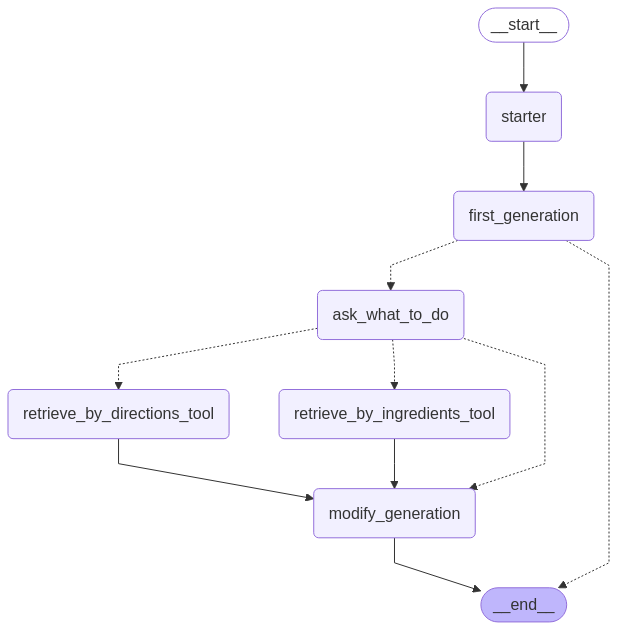

In [113]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod
display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [114]:
initial_state = {
                'messages': []
}

app.invoke(initial_state)

TerrierRetr(BM25): 100%|██████████| 1/1 [00:00<00:00, 20.41q/s]






Title: Simple Pan-Fried Chicken

Preparation Steps:
1. 1. Rinse the chicken and pat it dry with a clean towel.
2. 2. Heat the oil in a frying pan over medium-high heat.
3. 3. Once the oil is hot, add the chicken to the pan.
4. 4. Cook the chicken until it is browned and cooked through, about 10 minutes on each side.
5. 5. Once cooked, remove the chicken from the pan and let it rest for a few minutes before serving.
Modifying recipe...Do you need to change something?
content='{\n    "tool": "retrieve_by_ingredients",\n    "reasoning": "The recipe is a simple pan-fried chicken which only uses chicken and oil as ingredients. To improve this recipe, we can add more ingredients to enhance the flavor of the chicken. Let\'s see if we can find a more flavorful recipe using these ingredients.",\n    "action": "Retrieve more recipes using chicken and oil as main ingredients to add more flavor to the current recipe."\n}' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'

{'messages': [HumanMessage(content='chicken oil', additional_kwargs={}, response_metadata={}, id='348e8e38-03fb-4600-be2a-72046c1fb392'),
  AIMessage(content='{\n  "title": "Simple Pan-Fried Chicken",\n  "list_of_steps": [\n    "1. Rinse the chicken and pat it dry with a clean towel.",\n    "2. Heat the oil in a frying pan over medium-high heat.",\n    "3. Once the oil is hot, add the chicken to the pan.",\n    "4. Cook the chicken until it is browned and cooked through, about 10 minutes on each side.",\n    "5. Once cooked, remove the chicken from the pan and let it rest for a few minutes before serving."\n  ]\n}', additional_kwargs={}, response_metadata={}, id='df6ff416-4b4d-4639-94db-5a5070109b63'),
  AIMessage(content='{\n    "tool": "retrieve_by_ingredients",\n    "reasoning": "The recipe is a simple pan-fried chicken which only uses chicken and oil as ingredients. To improve this recipe, we can add more ingredients to enhance the flavor of the chicken. Let\'s see if we can find a